In [1]:
import gc
import os

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
file_path = "/Users/arnavkarnik/Documents/Recognition-of-Medicinal-Plant-Species-Deep-Learning-Project--Sem6/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/"

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# Data Generators
data_gen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

In [4]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    directory=file_path,
    target_size=(120, 120),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 1479 images belonging to 30 classes.


In [5]:
# Test Generator
test_generator = data_gen.flow_from_directory(
    directory=file_path,
    target_size=(120, 120),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 356 images belonging to 30 classes.


In [6]:
# Callback for tracking accuracy
class AccuracyLoggerCallback(Callback):
    def __init__(self, test_data, checkpoint_epochs):
        super().__init__()
        self.test_data = test_data
        self.checkpoint_epochs = checkpoint_epochs
        self.accuracy_log = {}

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.checkpoint_epochs:
            _, accuracy = self.model.evaluate(self.test_data, verbose=0)
            self.accuracy_log[epoch + 1] = accuracy
            print(f"Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%")

In [7]:
# Train function
def train_cnn_model(base_model, model_name):
    base_model = base_model(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

    # Unfreeze last 20 layers for fine-tuning
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])

    accuracy_callback = AccuracyLoggerCallback(test_data=test_generator, checkpoint_epochs=[5, 10, 15, 20])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(train_generator, epochs=20, batch_size=32, verbose=1, callbacks=[accuracy_callback, early_stopping])

    return model, accuracy_callback.accuracy_log

In [8]:
# Models to compare
models = {
    "ResNet50": ResNet50,
}

In [9]:
model_accuracies = {}
classification_reports = {}

# Directory for saving reports
os.makedirs("reports", exist_ok=True)

In [10]:
# Train and compare models
for model_name, base_model in models.items():
    print(f"Training {model_name}...")
    model, accuracy_log = train_cnn_model(base_model, model_name)
    model_accuracies[model_name] = accuracy_log

    # Generate predictions and classification report
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = test_generator.classes

    report = classification_report(y_true_classes, y_pred_classes, target_names=test_generator.class_indices.keys())
    classification_reports[model_name] = report

    # Save report to file
    with open(f"reports/{model_name}_classification_report.txt", "w") as file:
        file.write(report)

    # Clear session and memory
    del model
    tf.keras.backend.clear_session()
    gc.collect()

Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 30), output.shape=(None, 3)

Found 1479 images belonging to 30 classes.
Found 356 images belonging to 30 classes.
Class Distribution: {0: 40, 1: 98, 2: 45, 3: 48, 4: 83, 5: 28, 6: 60, 7: 46, 8: 40, 9: 51, 10: 35, 11: 57, 12: 50, 13: 78, 14: 62, 15: 45, 16: 48, 17: 50, 18: 32, 19: 42, 20: 39, 21: 39, 22: 49, 23: 52, 24: 64, 25: 47, 26: 32, 27: 45, 28: 45, 29: 29}
Training ResNet50...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.0553 - loss: 3.6456
Epoch 2/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step - accuracy: 0.1782 - loss: 2.9003
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.1942 - loss: 2.6617
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.2642 - loss: 2.4364
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.2707 - loss: 2.4240Accuracy at epoch 5: 5.06%
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 557ms/step - accuracy: 0.2710 - loss: 2.4225
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 436ms/step - accuracy: 0.2874 - loss: 2.2166
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 481ms/step - accuracy: 0.3230 - loss: 2.2748
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - accuracy: 0.3333 - loss: 2.1131
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 460ms/step - accuracy: 0.3616 - loss: 1.9860
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.3884 - loss: 1.9778Accuracy at epoch 10: 30.06%
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 581ms/step - accuracy: 0.3883 - loss: 1.9772
Epoch 11/20
47/47 ━━━━━

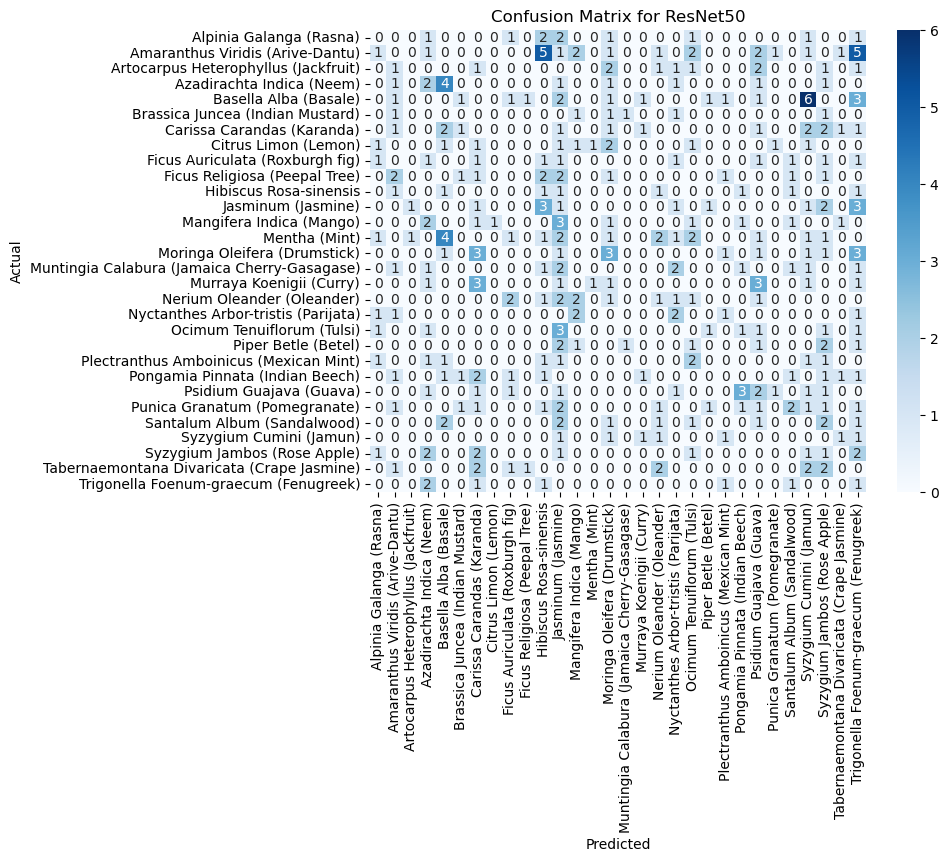

Best Model: ResNet50 with Accuracy at 20 epochs: 39.61%

Classification Report for ResNet50:
                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       0.00      0.00      0.00        10
            Amaranthus Viridis (Arive-Dantu)       0.00      0.00      0.00        24
        Artocarpus Heterophyllus (Jackfruit)       0.00      0.00      0.00        11
                   Azadirachta Indica (Neem)       0.12      0.17      0.14        12
                       Basella Alba (Basale)       0.00      0.00      0.00        20
            Brassica Juncea (Indian Mustard)       0.00      0.00      0.00         6
                  Carissa Carandas (Karanda)       0.00      0.00      0.00        14
                        Citrus Limon (Lemon)       0.00      0.00      0.00        11
             Ficus Auriculata (Roxburgh fig)       0.00      0.00      0.00        10
               Ficus Religiosa (Peepal Tree)  

In [11]:
import gc
import os

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Path
file_path = "/Users/arnavkarnik/Documents/Recognition-of-Medicinal-Plant-Species-Deep-Learning-Project--Sem6/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/"

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Train Generator
train_generator = data_gen.flow_from_directory(
    directory=file_path,
    target_size=(120, 120),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Test Generator
test_generator = data_gen.flow_from_directory(
    directory=file_path,
    target_size=(120, 120),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Print class distribution
class_counts = train_generator.classes
unique_classes, counts = np.unique(class_counts, return_counts=True)
class_distribution = dict(zip(unique_classes, counts))
print("Class Distribution:", class_distribution)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# Callback for tracking accuracy
class AccuracyLoggerCallback(Callback):
    def __init__(self, test_data, checkpoint_epochs):
        super().__init__()
        self.test_data = test_data
        self.checkpoint_epochs = checkpoint_epochs
        self.accuracy_log = {}

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.checkpoint_epochs:
            _, accuracy = self.model.evaluate(self.test_data, verbose=0)
            self.accuracy_log[epoch + 1] = accuracy
            print(f"Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%")

# Train function
def train_cnn_model(base_model, model_name):
    base_model = base_model(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

    # Unfreeze last 20 layers for fine-tuning
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(len(train_generator.class_indices), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])

    accuracy_callback = AccuracyLoggerCallback(test_data=test_generator, checkpoint_epochs=[5, 10, 15, 20])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f"{model_name}_best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")

    model.fit(
        train_generator,
        epochs=20,
        batch_size=32,
        verbose=1,
        class_weight=class_weights_dict,
        callbacks=[accuracy_callback, early_stopping, checkpoint]
    )

    return model, accuracy_callback.accuracy_log

# Models to compare
models = {
    "ResNet50": ResNet50,
}

model_accuracies = {}
classification_reports = {}

# Directory for saving reports
os.makedirs("reports", exist_ok=True)

# Train and compare models
for model_name, base_model in models.items():
    print(f"Training {model_name}...")
    model, accuracy_log = train_cnn_model(base_model, model_name)
    model_accuracies[model_name] = accuracy_log

    # Generate predictions and classification report
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = test_generator.classes

    report = classification_report(y_true_classes, y_pred_classes, target_names=test_generator.class_indices.keys())
    classification_reports[model_name] = report

    # Save report to file
    with open(f"reports/{model_name}_classification_report.txt", "w") as file:
        file.write(report)

    # Generate Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), 
                yticklabels=test_generator.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.savefig(f"reports/{model_name}_confusion_matrix.png")
    plt.show()

    # Clear session and memory
    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Determine best model
best_model_name = max(model_accuracies, key=lambda k: model_accuracies[k].get(20, 0))
best_model_accuracy = model_accuracies[best_model_name].get(20, 0)
print(f"Best Model: {best_model_name} with Accuracy at 20 epochs: {best_model_accuracy * 100:.2f}%")

# Print classification reports
for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    print(report)
